# Hands-On NLP — Class 2

<span style="color:magenta">Group members:</span>

* Elizaveta Sirotina
* Ahmed Nazar
* Petko Petkov

## Outline

- Embeddings from scratch

- Classifications with embeddings

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
import time

In [2]:
tqdm.pandas()

nltk.download("punkt")
nltk.download('punkt_tab')

print("sklearn", sklearn.__version__)   # 1.3.2

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 2)

sklearn 1.6.1


[nltk_data] Downloading package punkt to /home/petko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/petko/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
TEXT_P = Path("texts")

CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

EPS = np.finfo(float).eps

## Getting the data

In [4]:
corpora = {}
stats = []

for corpus in tqdm(CORPORA):
    print(corpus)
    texts = []
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            texts.append(f.read())

    corpora[corpus] = "".join(texts)

    stats.append(
        {
            "corpus": corpus,
            "files_n": len(texts),
            "chars_n": len(corpora[corpus]),
        }
    )

df = pd.DataFrame.from_records(stats, index=["corpus"])
df["text"] = [corpora[corpus] for corpus in corpora]
df

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


,files_n,chars_n,text
corpus,,,
mythology,1503,4968342,Q:\n\nWhy were the Greek Gods on Olympus?\n\nI...
woodworking,2860,7839486,Q:\n\nIs support on three sides of a long popl...
robotics,39674,110877047,Q:\n\nErrors compiling Rosjava code\n\nI am ha...
hsm,2887,9466140,Q:\n\nAnalysis vs Synthesis in Greek Mathemati...
health,3733,10214223,Q:\n\nCan Sour/Acidic Food reduce libido in me...
portuguese,2026,4827567,Q:\n\nTradução de “full volume”\n\nEm inglês t...


### Tokenizing

In [5]:
# If your machine is slow, pickeling allows to go faster next time.

tokens_fp = "tokens.pkl"
try:
    tokens = pd.read_pickle(tokens_fp)
except FileNotFoundError:
    tokens = df.text.progress_map(word_tokenize)
    tokens.to_pickle(tokens_fp)

  0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
df["tokens"] = tokens
df["tokens_n"] = df.tokens.map(len)
df["types_n"] = df.tokens.map(set).map(len)
df

,files_n,chars_n,text,tokens,tokens_n,types_n
corpus,,,,,,
mythology,1503,4968342,Q:\n\nWhy were the Greek Gods on Olympus?\n\nI...,"[Q, :, Why, were, the, Greek, Gods, on, Olympu...",998926,53030
woodworking,2860,7839486,Q:\n\nIs support on three sides of a long popl...,"[Q, :, Is, support, on, three, sides, of, a, l...",1620394,35469
robotics,39674,110877047,Q:\n\nErrors compiling Rosjava code\n\nI am ha...,"[Q, :, Errors, compiling, Rosjava, code, I, am...",20494962,502398
hsm,2887,9466140,Q:\n\nAnalysis vs Synthesis in Greek Mathemati...,"[Q, :, Analysis, vs, Synthesis, in, Greek, Mat...",1865024,74635
health,3733,10214223,Q:\n\nCan Sour/Acidic Food reduce libido in me...,"[Q, :, Can, Sour/Acidic, Food, reduce, libido,...",1915518,71817
portuguese,2026,4827567,Q:\n\nTradução de “full volume”\n\nEm inglês t...,"[Q, :, Tradução, de, “, full, volume, ”, Em, i...",992726,63863


## Vectorization

### 🚧 TODO: How to vectorize text?

- Try counting words in the stackoverflow corpus based on a given vocabulary

- Apply reduction techniques to reduce the dimensionality to 2 dimensions (e.g., PCA)

- Plot the 2D vectors

In [7]:
words = (
    "myth,wood,robot,history,science,mathematics,health,portuguese,o".split(",")
)
wc_df = pd.DataFrame(index=df.index)
for w in words:
    wc_df[w] = df['tokens'].apply(lambda tokens: tokens.count(w))

In [8]:
wc_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
corpus,,,,,,,,,
mythology,826,60,6,187,23,5,21,0,29
woodworking,7,8773,0,20,10,1,49,0,2
robotics,1,35,34760,225,49,66,27,3,235
hsm,36,16,4,1170,1033,1965,34,2,40
health,47,10,1,239,127,10,1709,1,3
portuguese,2,11,3,13,3,2,8,46,16006


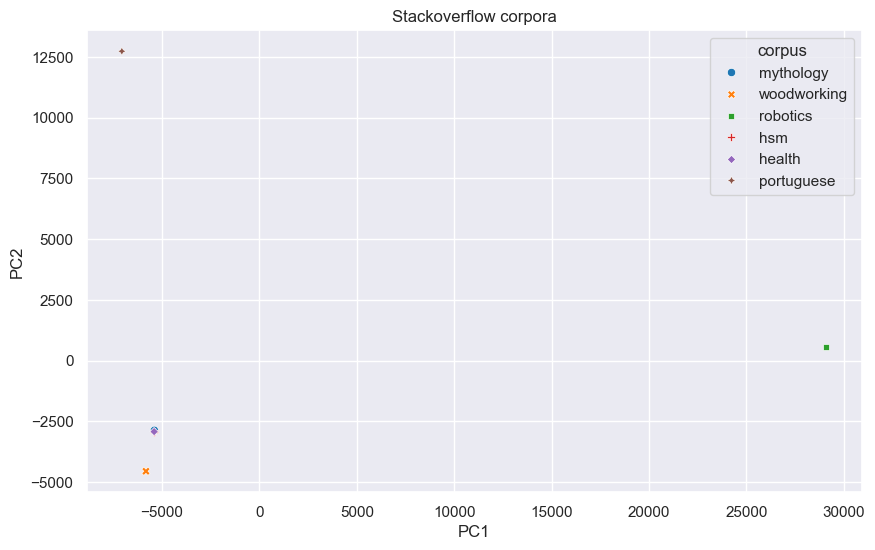

In [9]:
pca = PCA(n_components=2)
wc_df_pca = pca.fit_transform(wc_df)

wc_df_pca_df = pd.DataFrame(wc_df_pca, columns=['PC1', 'PC2'], index=wc_df.index)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=wc_df_pca_df, hue=wc_df_pca_df.index, style=wc_df_pca_df.index)
plt.title('Stackoverflow corpora')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Most of the corpora are clustered together which means that they have similar content characteristics. However, Robotics and Portuguese corpora stand out. Portuguese one differs a lot because other corpora are in English. Robotics corpus contains a lot of programming code blocks. 

#### Bag of words

### 🚧 TODO: Implement another bag of words vectorizer model on the corpus

*   This time using [sklearn's `CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

*   Try first the provided example in the `CountVectorizer` documentation

    Try with and without the n-gram parameter

*   Then try to vectorize the stackoverflow corpus using `vocabulary=words`

#### First with a toy example

In [10]:
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

With the whole vocabulary

In [11]:
vectorizer = CountVectorizer()
xs = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out())
print(xs.toarray())

vectorizer_2g = CountVectorizer(analyzer='word', ngram_range=(2, 2))
x2gs = vectorizer_2g.fit_transform(corpus)

print(vectorizer_2g.get_feature_names_out())

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
['and this' 'document is' 'first document' 'is the' 'is this'
 'second document' 'the first' 'the second' 'the third' 'third one'
 'this document' 'this is' 'this the']


In [12]:
cv_df = pd.DataFrame(xs.toarray(), columns=vectorizer.get_feature_names_out())
cv_df.insert(0, "Document", corpus)
cv_df

,Document,and,document,first,is,one,second,the,third,this
0,This is the first document.,0,1,1,1,0,0,1,0,1
1,This document is the second document.,0,2,0,1,0,1,1,0,1
2,And this is the third one.,1,0,0,1,1,0,1,1,1
3,Is this the first document?,0,1,1,1,0,0,1,0,1


With a subset of the vocabulary

In [13]:
vocabulary = ["and", "document", "first"]
vectorizer = CountVectorizer(vocabulary=vocabulary)
xs = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
print(xs.toarray())

['and' 'document' 'first']
[[0 1 1]
 [0 2 0]
 [1 0 0]
 [0 1 1]]


In [14]:
cv_df = pd.DataFrame(xs.toarray(), columns=vectorizer.get_feature_names_out())
cv_df.insert(0, "Document", corpus)
cv_df

,Document,and,document,first
0,This is the first document.,0,1,1
1,This document is the second document.,0,2,0
2,And this is the third one.,1,0,0
3,Is this the first document?,0,1,1


#### Reprocess the stackoverflow corpora with `CountVectorizer`

In [19]:
vectorizer = CountVectorizer(vocabulary=words)
xs = vectorizer.fit_transform(df['text'])

print(vectorizer.get_feature_names_out())
print(xs.toarray())

['myth' 'wood' 'robot' 'history' 'science' 'mathematics' 'health'
 'portuguese' 'o']
[[  924    79     6   319    38     5    26     4     0]
 [    7  9335     1    21    18     1    54     0     0]
 [    1    45 40512   286    93    81    28     6     0]
 [   39    19     4  1891  1459  2631    46    11     0]
 [   56    16     1   277   294    14  2379     4     0]
 [    2    13     3    20     7     6     9  1199     0]]


### 🚧 TODO: Why is this different?

- Try to explain

- Give a simple example with the toy corpus below (with the same vocabulary)

It is different because CountVectorizer preprocesses the text before the tokenization while in simple word count we do not do anything with the text. For example, in word count tokens "myth" and "Myth" are too different ones. While by default in CountVectorizer the text is lowercased before tokenization. If we set lowercase=False, then we will get a number closer to the one that we got for simply counting words.

In [20]:
vectorizer_example = CountVectorizer(vocabulary=words, lowercase=False)
xs_example = vectorizer_example.fit_transform(df['text'])

print(vectorizer_example.get_feature_names_out())
print(xs_example.toarray())

['myth' 'wood' 'robot' 'history' 'science' 'mathematics' 'health'
 'portuguese' 'o']
[[  850    65     6   198    29     5    22     0     0]
 [    7  8976     1    20    13     1    49     0     0]
 [    1    36 37979   261    70    75    27     3     0]
 [   36    16     4  1227  1073  1992    36     2     0]
 [   47    11     1   244   194    11  1862     1     0]
 [    2    11     3    15     3     3     8    54     0]]


In [65]:
test_text = (
    "myth wood robot history science mathematics health portuguese o "
    "myth Wood robot history science mathematics HEALTH ;portuguese o"
)

freqs = {word: test_text.split().count(word) for word in words}
test_wc_df = pd.DataFrame([freqs])

test_wc_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
0,2,1,2,2,2,2,1,1,2


In [44]:
vectorizer = CountVectorizer(vocabulary=words)
test_xs = vectorizer.fit_transform([test_text])
test_cv_df = pd.DataFrame(test_xs.toarray(), columns=vectorizer.get_feature_names_out())

test_cv_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
0,2,2,2,2,2,2,2,2,0


### 🚧 TODO: Is this difference important?

• Visualize the PCAs of both models

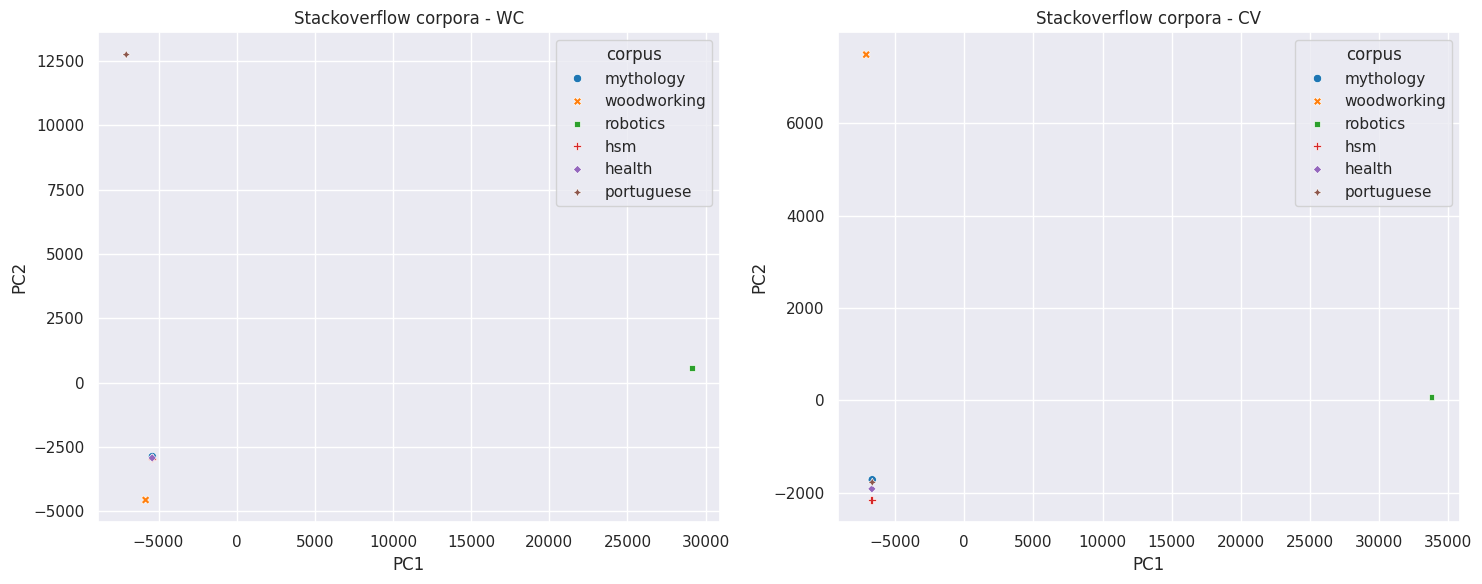

In [63]:
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(15, 6))

# word count
pca = PCA(n_components=2)
wc_df_pca = pca.fit_transform(wc_df)

wc_df_pca_df = pd.DataFrame(wc_df_pca, columns=['PC1', 'PC2'], index=wc_df.index)

sns.scatterplot(ax=plt1, x='PC1', y='PC2', data=wc_df_pca_df, hue=wc_df_pca_df.index, style=wc_df_pca_df.index)
plt1.set_title('Stackoverflow corpora - WC')
plt1.set_xlabel('PC1')
plt1.set_ylabel('PC2')

# count vectorizer
pca = PCA(n_components=2)
cv_df_pca = pca.fit_transform(cv_df)

cv_df_pca_df = pd.DataFrame(cv_df_pca, columns=['PC1', 'PC2'], index=cv_df.index)

sns.scatterplot(ax=plt2, x='PC1', y='PC2', data=cv_df_pca_df, hue=cv_df_pca_df.index, style=cv_df_pca_df.index)
plt2.set_title('Stackoverflow corpora - CV')
plt2.set_xlabel('PC1')
plt2.set_ylabel('PC2')

plt.tight_layout()
plt.show()


Yes, the difference is important. We see that on the WC plot the Portuguese and Robotics stand out, while on the CV plot Woodworking and Robotics are the outliers. 

We assume that it happens because in Word Count Portuguese stands out due to frequent use of "o", while Count Vectorizer handles word boundaries and tokenization. So, in the second case "o" is recognized as part of words, not as a unique token.

Robotics has many occurrences of technical words like "robot" and it remains an outlier in both cases. Woodworking stands out also because of its specific terms such as "wood". 

-----------

### The corpus as individual documents

In [22]:
data = []

for i, corpus in enumerate(tqdm(CORPORA)):
    print(corpus)
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            text = f.read()
        data.append(
            {
                "id": fp.stem,
                "text": text,
                "category": corpus,
                "cat_id": i,
            }
        )

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


In [23]:
doc_df = pd.DataFrame.from_records(data).set_index("id")
doc_df

,text,category,cat_id
id,,,
mythology.stackexchange_0000004671,Q:\n\nWhy thank the person who is cutting out ...,mythology,0
mythology.stackexchange_0000004882,Q:\n\nGods from different cultures accepted in...,mythology,0
mythology.stackexchange_0000004764,Q:\n\nWho was Thalia's mother?\n\nI do not mea...,mythology,0
mythology.stackexchange_0000000665,Q:\n\nJuno and one of the Fabian laws\n\nIn Ro...,mythology,0
mythology.stackexchange_0000000898,Q:\n\nThe Last Glacial Period in Myth\n\nMany ...,mythology,0
...,...,...,...
portuguese.stackexchange_0000003353,"Q:\n\nQual a origem do termo ""moleque""?\n\nEss...",portuguese,5
portuguese.stackexchange_0000003002,"Q:\n\nIs there any Portuguese word for ""crowds...",portuguese,5
portuguese.stackexchange_0000002962,Q:\n\nComo é que um falante pode fazer a disti...,portuguese,5


#### 🚧 TODO: Plot (bar) the number of documents per category

In [24]:
doc_df['category'].value_counts()

category
robotics       39674
health          3733
hsm             2887
woodworking     2860
portuguese      2026
mythology       1503
Name: count, dtype: int64

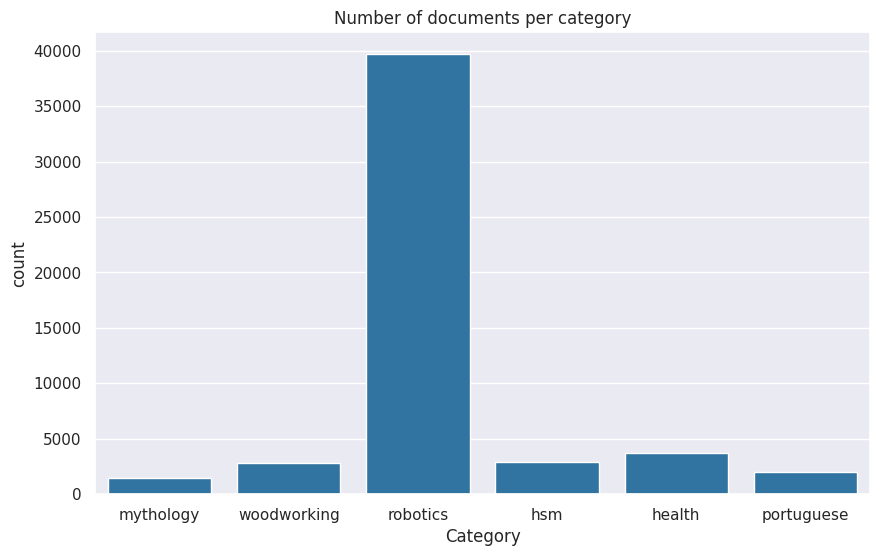

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(data=doc_df, x='category')
plt.title('Number of documents per category')
plt.xlabel('Category')
plt.xticks()
plt.show()

#### 🚧 TODO: Boxplot the number of tokens per document

* With and without outliers

* Shortly explain the different values presented in a boxplot ([Wikipedia](https://en.wikipedia.org/wiki/Box_plot))

* Are the texts of signifcantly different length? Argue shortly.

In [26]:
# Careful: slow!

doc_df["tokens"] = doc_df.text.progress_map(word_tokenize)
doc_df["tokens_n"] = doc_df.tokens.map(len)

  0%|          | 0/52683 [00:00<?, ?it/s]

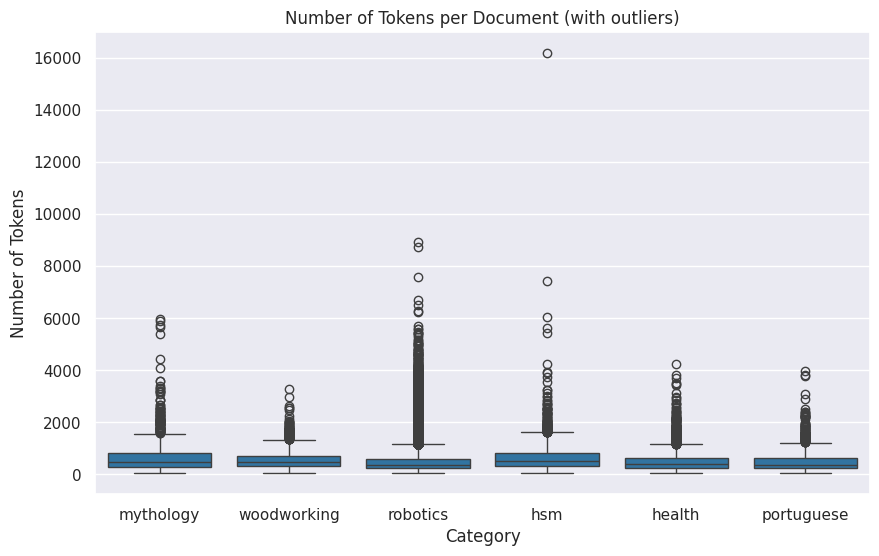

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="category", y="tokens_n", data=doc_df)
plt.title("Number of Tokens per Document (with outliers)")
plt.xlabel("Category")
plt.ylabel("Number of Tokens")
plt.show()

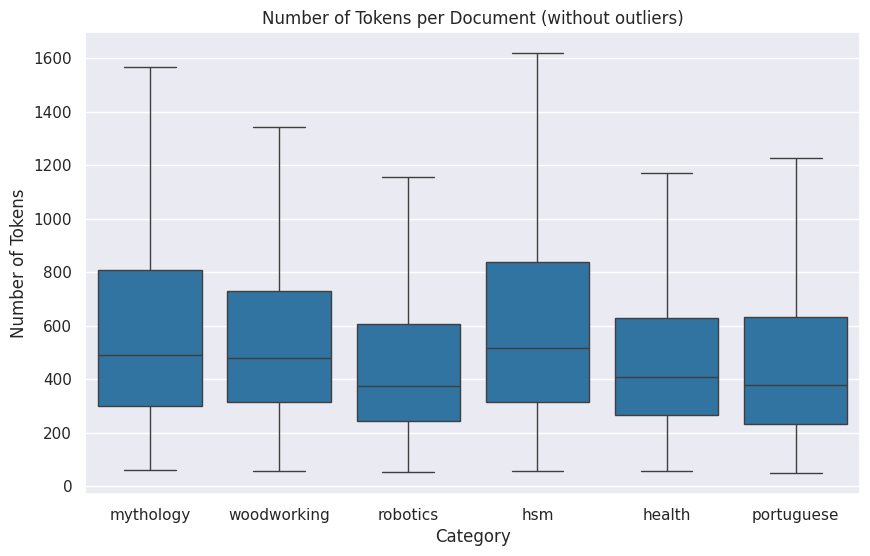

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="category", y="tokens_n", data=doc_df, showfliers=False)
plt.title("Number of Tokens per Document (without outliers)")
plt.xlabel("Category")
plt.ylabel("Number of Tokens")
plt.show()

Mythology, robotics and hsm have a lot of outliers. Having a high number of tokens suggests that some of the documents are significantly longer and more variable.

Mythology, woodworking and hsm have higher medians compared to robotics, health and portuguese. Documents in robotics, health and portuguese have less variablity within a category than other ones (they have smaller interquartile range). Also, all categories have a similar lower bound for token counts.

#### 🚧 TODO: How to find the crazy long robotics text?

*   Find the index of the longest text

*   Show the content

*   Explain why this text is so long (what does it contain?)

In [29]:
longests_df = doc_df[doc_df["category"] == "robotics"]

longest_index = longests_df["tokens_n"].idxmax()
longest_text = doc_df.loc[longest_index, "text"]

print(f"Index of the longest text: {longest_index}")
print(f"Number of tokens: {longests_df.loc[longest_index, 'tokens_n']}")
print(longest_text)

Index of the longest text: robotics.stackexchange_0000044556
Number of tokens: 8955
Q:

Synchronization with 8 incoming channels, registerCallback boost::bind -> compilation error

Hi all,
UPDATE: I found a workaround which I posted at the end of this question
I try to use ApproximateTime Synchronization with 8 channels, but I get a compilation error. Strangely it works with 4.
Here's some of the code:
(The error is at sync_->registerCallback(boost::bind(&S2::filter_image, this,  _1, _2, _3, _4, _5, _6, _7, _8, "ok")); )
class S2 {
    ros::NodeHandle nh_;
    
    image_transport::ImageTransport image_transporter_;
    boost::unordered_map<std::string, boost::shared_ptr<image_transport::SubscriberFilter> > response_; //images from C1

    //Synchronizer
    typedef message_filters::sync_policies::ApproximateTime<sensor_msgs::Image, sensor_msgs::Image,
        sensor_msgs::Image, sensor_msgs::Image,
        sensor_msgs::Image, sensor_msgs::Image,
        sensor_msgs::Image, sensor_msgs

This text contains a conversation with multiple logs of errors. Usually error logs include a lot of text with unique names of different classes and variables.

### Vectorizing again

#### 🚧 TODO: See how many features we get if we don't restrict their number

* Use again the `CountVectorizer` to vectorize the stackoverflow corpus

  * But use the whole vocabulary of the documents this time (**without** `vocabulary=words`)

  * Tell how many features are obtained

* Then limit the vocabulary to the 5000 most frequent words

* Apply and plot dimensionality reduction to 2 dimensions as prevously
  (only on the limited vocabulary)

We want something like this:

```python
xs ~ doc_df.text
ys ~ doc_df.cat_id
```

In [30]:
ys = doc_df.cat_id.values

In [31]:
unconstrained_cv = CountVectorizer()
xs = unconstrained_cv.fit_transform(doc_df.text)

print(f"Number of features: {len(unconstrained_cv.get_feature_names_out())}")

Number of features: 396573


In [32]:
cv = CountVectorizer(max_features=5000)
xs = cv.fit_transform(doc_df.text)

print(f"Number of features: {len(cv.get_feature_names_out())}")

Number of features: 5000


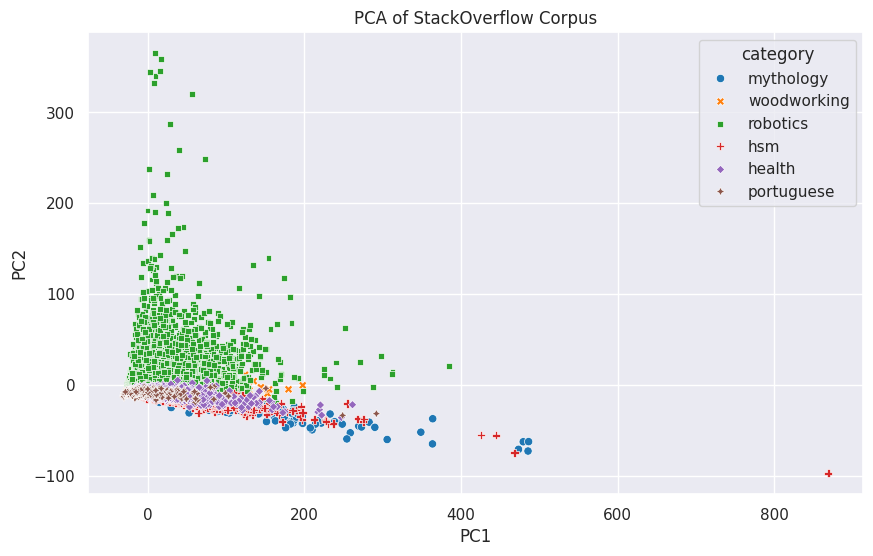

In [33]:
pca = PCA(n_components=2)
xs_pca = pca.fit_transform(xs.toarray())
xs_pca_df = pd.DataFrame(xs_pca, columns=['PC1', 'PC2'])
xs_pca_df['category'] = doc_df['category'].values

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=xs_pca_df, hue='category', style='category')
plt.title('PCA of StackOverflow Corpus')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### 🚧 TODO: Find that outlier!

* Use pandas to find the document corresponding to the outlier

* Print the correspoding text
  
* Tell what it contains (if you could figure it out)

* Remove the corresping raw from the dataframe and redo the dimensional reduction (and plot)

In [34]:
outlier_index = xs_pca_df["PC1"].idxmax()
outlier_doc_id = doc_df.index[outlier_index]

print(doc_df.loc[outlier_doc_id, "text"])

Q:

Conditionally convergent series

I am looking for the original reference discussing a specific, elementary example of a rearrangement of series converging to a value different from the original series. In what follows, I give some (meager) context and make explicit the example whose origin I am trying to locate.

Apparently, Dirichlet was first to note that a conditionally convergent series may be rearranged so that the resulting series converges to a different value. In 1837, in his paper showing that any arithmetic progression $(a+bn)_{n\ge0}$ contains infinitely many primes provided that $a,b$ are relatively prime, he gives an example and also proves that rearranging an absolutely convergent series has no effect on its limit.
In 1853, Riemann proved his rearrangement theorem, although it was not published until 1866, as part of his Habilitationsschrift on representation of functions as trigonometric series. See here for Riemann's papers.

Theorem (Riemann). Given any α≤β in the 

#### 🚧 TODO: The reason for this outlier is...

*   Give a short explanation

*   Remove the outlier from the dataframe

*   Redo the dimensional reduction

*   Plot the 2D vectors and color them by category

The outlier seems to be an extremely detailed question and answer related to some historical mathematical concepts. It describes Dirichlet's 1837 paper on rearranging terms in conditionally convergent series which consists of a lot of Theoremas, explanations and formulas. Also, it seems to include a lot of citations.

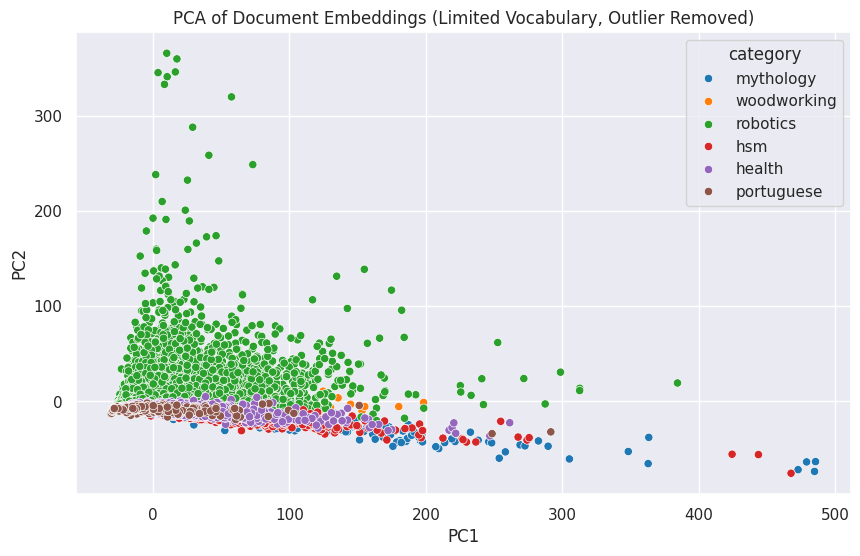

In [35]:
xs_pca_df_no_outlier = xs_pca_df.drop(index=outlier_index)

xs_limited_no_outlier = xs[xs_pca_df_no_outlier.index]

pca_no_outlier = PCA(n_components=2, random_state=0)
xs_pca_df_no_outlier_new = pd.DataFrame(pca_no_outlier.fit_transform(xs_limited_no_outlier.toarray()), columns=["PC1", "PC2"])
xs_pca_df_no_outlier_new["category"] = xs_pca_df_no_outlier["category"]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=xs_pca_df_no_outlier_new, x="PC1", y="PC2", hue="category")
plt.title("PCA of Document Embeddings (Limited Vocabulary, Outlier Removed)")
plt.show()

## Train models to predict text subjects

### Split the data in training and test sets

In [36]:
train_xs, test_xs, train_ys, test_ys = model_selection.train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(36878, 5000)
(15805, 5000)


### 🚧 TODO: Apply different algorithms to try predicting the category

* E.g., Logistic Regression, Multinomial Naive Bayes, Decision Tree Classifier, Random Forest, Support Vector Classifer.

* You could investigate [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), which implements linear classifiers (e.g, SVM, logistic regression) with SGD training (faster).

* Present a table with the results of the different algorithms (e.g., accuracy, precision, recall, f1-score) and their execution time

* (Optional) Analyse 1 algorythm in detail (e.g., Logistic Regression)

  *   Try different parameters (possibly with a grid search)

  *   Present the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

  *   Present the confusion matrix of the best model

In [37]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=0),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Support Vector Classifier": SVC(random_state=0),
    "SGD Classifier": SGDClassifier(random_state=0)
}

results = []

for name, clf in classifiers.items():
    start_time = time.time()
    clf.fit(train_xs, train_ys)
    predictions = clf.predict(test_xs)
    end_time = time.time()
    
    accuracy = accuracy_score(test_ys, predictions)
    report = classification_report(test_ys, predictions, output_dict=True)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
        "Time (s)": end_time - start_time
    })

results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1-Score,Time (s)
0,Logistic Regression,0.99,0.99,0.99,0.99,17.05
1,Multinomial Naive Bayes,0.97,0.97,0.97,0.97,0.05
2,Decision Tree,0.96,0.96,0.96,0.96,5.33
3,Random Forest,0.99,0.99,0.99,0.99,30.37
4,Support Vector Classifier,0.98,0.98,0.98,0.98,412.52
5,SGD Classifier,0.99,0.99,0.99,0.99,1.21


Best parameters: {'alpha': 0.0001}
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       433
           1       0.87      1.00      0.93       879
           2       1.00      0.98      0.99     11888
           3       0.86      0.95      0.91       816
           4       0.95      0.98      0.97      1151
           5       1.00      0.94      0.97       638

    accuracy                           0.98     15805
   macro avg       0.93      0.97      0.95     15805
weighted avg       0.98      0.98      0.98     15805



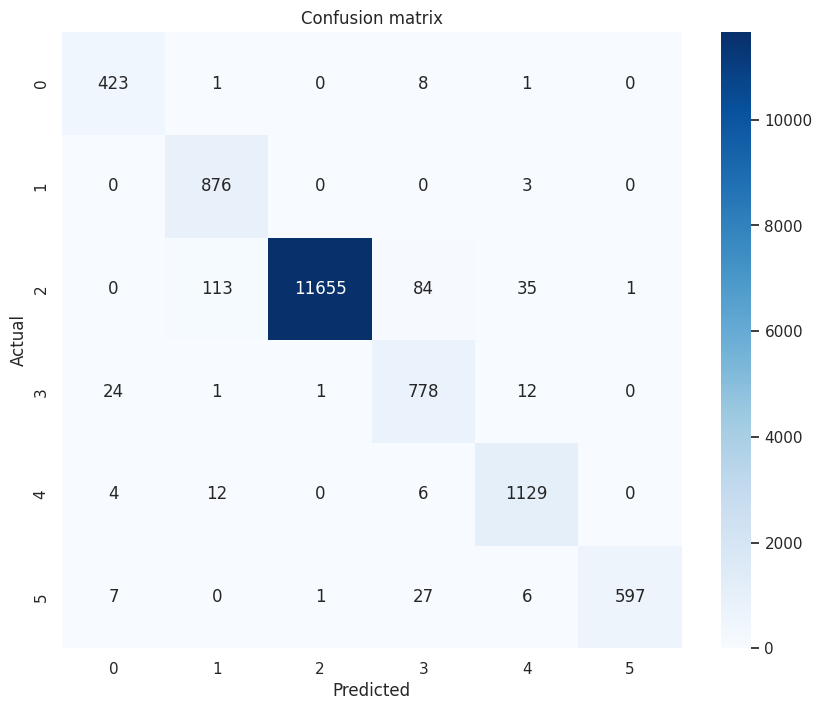

In [38]:
param_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1],
}

grid_search = GridSearchCV(
    MultinomialNB(),
    param_grid, 
    cv=3, 
    scoring="f1_weighted"
)

grid_search.fit(train_xs, train_ys)

best_nb = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

predictions = best_nb.predict(test_xs)
print(classification_report(test_ys, predictions))

conf_matrix = confusion_matrix(test_ys, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_ys), yticklabels=np.unique(test_ys))
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 🚧 TODO: Explain what model seems to work best

Logistic Regression, Random Forest and SGD Classifier all perform excellently with an accuracy, precision, recall, and F1 score of 0.99. However, time-wise SGD Classifier is more efficient.

Multinomial Naive Bayes has the fastest execution time, though it has slightly lower metrics compared to the top-performing models. Yet, in the case when time is critical, this model still can be used.

SGD Classifier seems to be the best overall. It returns high result in a short time.

____